Recursive Control Variates for Inverse Rendering
===============================================

Overview
--------
When optimising scenes with Monte-Carlo differentiable rendering, we feed noisy images through objective functions. When these functions have a nonlinear derivative (e.g. L1), bias arises. 

In this notebook, we will illustrate this issue, and show how to use our control variates to mitigate this issue.

Setup
-----

As usual, let's import `drjit` and `mitsuba` and set a differentiation-aware variant.

In [1]:
import mitsuba as mi
mi.set_variant('cuda_ad_rgb')
import drjit as dr
from mitsuba.scalar_rgb import Transform4f as T

import matplotlib.pyplot as plt
import numpy as np

Scene construction
------------------

We setup a simple scene: a Stanford bunny with inside a Cornell box. The bunny has a rough dielectric surface and a homogeneous medium inside. We will optimise the medium's extinction coefficient.

In [2]:
scene_dict = mi.cornell_box()
del scene_dict['small-box']
del scene_dict['large-box']

scene_dict['bunny'] = {
    'type': 'ply',
    'filename': 'scenes/common/meshes/bunny.ply',
    'to_world': T.translate((0,-0.58,0)).scale(8),
    'bsdf': {
        'type': 'roughdielectric',
        'alpha': 0.1
    }
}

medium = {
    'type': 'homogeneous',
    'scale': 5,
    'sigma_t': {
        'type': 'spectrum',
        'value': 2.5
    },
    'albedo': {
        'type': 'rgb',
        'value': (0.85,0.97,0.999999)
    }
}

scene_dict['bunny']['interior'] = medium
scene = mi.load_dict(scene_dict)
integrator = mi.load_dict({'type': 'prbvolpath', 'max_depth': 16, 'rr_depth': 16})

In [3]:
ref_img = mi.render(scene, integrator=integrator, spp=8192)

Let's visualize the target state:

(-0.5, 255.5, 255.5, -0.5)

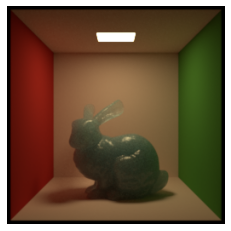

In [4]:
plt.imshow(mi.util.convert_to_bitmap(ref_img))
plt.axis('off')

We define a few optimisation hyper-parameters

In [5]:
initial_sigmat = 0.2
n_steps = 150
spp = 2
spp_grad = 16
lr = 1e-1

Baseline optimisation
---------------------

We will first try to recover the extinction coefficient using an off-the-shelf from Mitsuba: the `prbvolpath` integrator.

In [6]:
params = mi.traverse(scene)
key = 'bunny.interior_medium.sigma_t.value.value'
opt = mi.ad.Adam(lr=lr)
opt[key] = mi.Float(initial_sigmat)


In [7]:
for it in range(n_steps):
	params.update(opt)
	img = mi.render(scene, params, integrator=integrator, spp=spp, spp_grad=spp_grad, seed=it)
	# L1 loss
	loss = dr.mean(dr.abs(img - ref_img))
	dr.backward(loss)
	opt.step()
	opt[key] = dr.clamp(dr.detach(opt[key]), 1e-3, 10)
	print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')


In [8]:
params.update(opt)
img_baseline = mi.render(scene, integrator=integrator, spp=8192)

Let's look at the final result. As you can see, the optimisation converged far from the target state. This is caused by the nonlinearity in the L1 loss derivative.

Text(0.5, 1.0, 'Target')

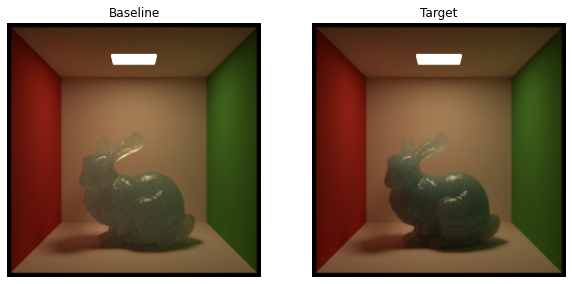

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(mi.util.convert_to_bitmap(img_baseline))
ax[0].axis('off')
ax[0].set_title('Baseline')
ax[1].imshow(mi.util.convert_to_bitmap(ref_img))
ax[1].axis('off')
ax[1].set_title('Target')

Recursive Control Variates
--------------------------

We will now use our control variates to run the same optimisation. The key idea is, at each iteration, to reuse the previously rendered images as guides to reduce the noise in the current rendering, thus reducing the bias. 

To use it, we need to use a few custom Mitsuba plugins, defined in the `plugins` folder

In [10]:
import plugins

We will need the following elements:
- a `twostate` adapter around our medium, that will allow us to store two consecutive optimisation states.
  - This adapter stores three copies of the same medium: the previous state, the current one, and another for gradient computation. These should be given the same medium dictionary as input.
- a `twostate` integrator, that renders the optimised scene using those consecutive states, yielding correlated renderings.
  - This one is initialised like off-the-shelf integrators.
- the `cv` integrator, which uses these correlated renderings to compute the control variates.
  - This one expects a `twostate` integrator as a nested integrator. One can also specify a different integrator for the adjoint phase (e.g. DRT) if desired.

In [11]:
scene_dict['bunny']['interior'] = {
	'type': 'twostatemedium',
	'old': medium,
	'new': medium,
	'incoming': medium
}
scene = mi.load_dict(scene_dict)
integrator = mi.load_dict({
	'type': 'cv',
	'integrator': {
		'type': 'twostateprbvolpath',
		'max_depth': 16,
		'rr_depth': 16
	}
})
params = mi.traverse(scene)

In [12]:
opt = mi.ad.Adam(lr=lr)
opt[key] = mi.Float(initial_sigmat)
params.update(opt);

With all that done, we can run our optimisation again, with no other changes to the optimisation code.

In [13]:
for it in range(n_steps):
	params.update(opt)
	img = mi.render(scene, params, integrator=integrator, spp=spp, spp_grad=spp_grad, seed=it)
	# L1 loss
	loss = dr.mean(dr.abs(img - ref_img))
	dr.backward(loss)
	opt.step()
	opt[key] = dr.clamp(dr.detach(opt[key]), 1e-3, 10)
	print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')


In [14]:
params.update(opt)
img_cv = mi.render(scene, integrator=mi.load_dict({'type': 'prbvolpath', 'max_depth': 16, 'rr_depth': 16}), spp=8192)

Final results
------------

We can compare the final optimisation state with and without control variates. Using control variates helps reduce the gradient bias, thus converging closer to the target image.

Text(0.5, 1.0, 'Target')

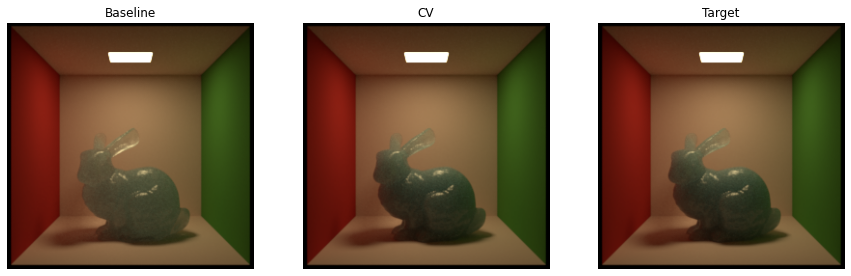

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(mi.util.convert_to_bitmap(img_baseline))
ax[0].axis('off')
ax[0].set_title('Baseline')
ax[1].imshow(mi.util.convert_to_bitmap(img_cv))
ax[1].axis('off')
ax[1].set_title('CV')
ax[2].imshow(mi.util.convert_to_bitmap(ref_img))
ax[2].axis('off')
ax[2].set_title('Target')